In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from scipy.stats.distributions import chi2
from sklearn.metrics import mean_absolute_error
import warnings

# Ex. 1: MA model

In [3]:
def MA(steps, df: np.array, c, phi: np.array, burnin):

    #generating white noise
    np.random.seed(100)
    noise = np.random.normal(0, 1, steps + burnin)

    res = df

    #start calculating the MA model
    for i in range(len(df) - 1, steps + burnin):

        new = c

        #adding previous values of error
        for j in range(0, len(phi)):
            new += phi[j] * noise[i - (j + 1)]

        #adding white noise
        new += noise[i]

        #appending new value
        res = np.append(res, new)

    #discarding first n values
    dlt = np.arange(burnin)
    res = np.delete(res, dlt, 0)

    return res

In [4]:
def AR(steps, df: np.array, c, phi: np.array, burnin):

    #generating white noise
    np.random.seed(100)
    noise = np.random.normal(0, 1, steps + burnin)

    res = df

    #start calculating the AR model
    for i in range(len(df) - 1, steps + burnin):

        #adding constant and white noise
        new = c + noise[i]

        #adding previous values of res
        for j in range(0, len(phi)):
            new += phi[j] * res[i - j]

        #appending new value
        res = np.append(res, new)

    #discarding first n values
    dlt = np.arange(burnin)
    res = np.delete(res, dlt, 0)

    return res

### y_t = 20 + e_t + 0,8*e_(t-1)

C:\Users\Rudy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


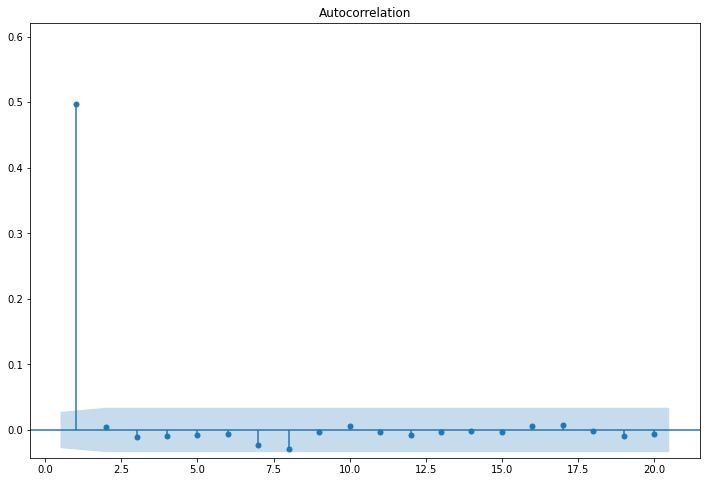

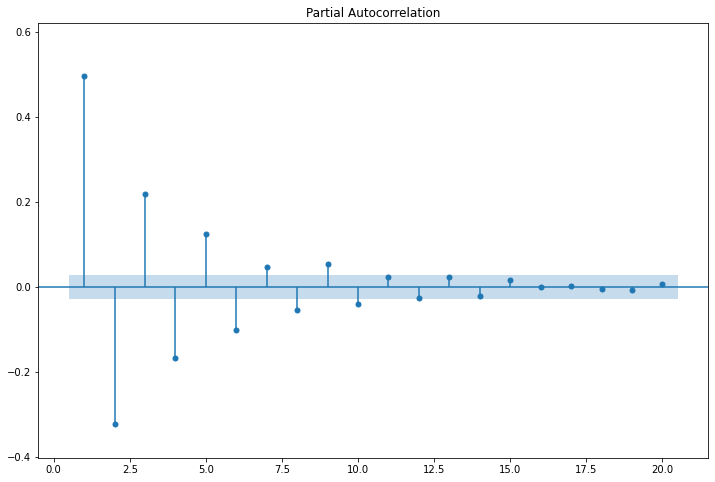

In [5]:
df = MA(5000, np.array([1]), 20, np.array([0.8]), 200)

plt.rc("figure", figsize=(12,8))
plot_acf(df, lags = 20, zero = False, auto_ylims = True);
plot_pacf(df, lags = 20, zero = False, auto_ylims = True);

C:\Users\Rudy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


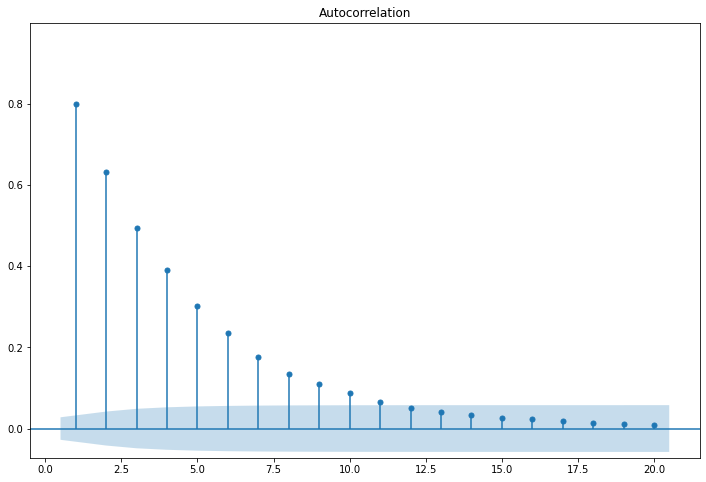

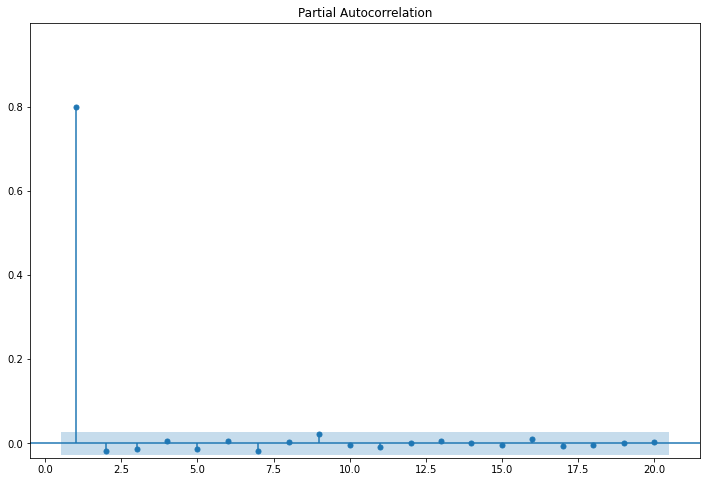

In [6]:
df2 = AR(5000, np.array([1]), 20, np.array([0.8]), 200)

plt.rc("figure", figsize=(12,8))
plot_acf(df2, lags = 20, zero = False, auto_ylims = True);
plot_pacf(df2, lags = 20, zero = False, auto_ylims = True);

##### MA model can be identified by ACF plot, while AR model can be identified by PACF plot

### y_t = e_t - e_(t-1) + 0.8*e_(t-2)

C:\Users\Rudy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


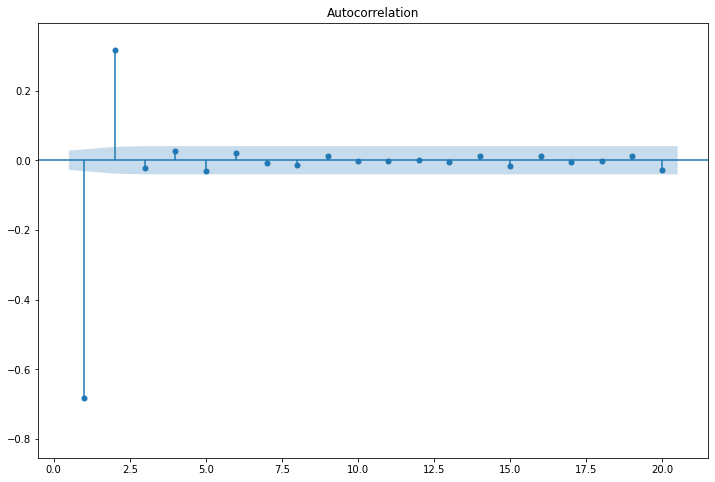

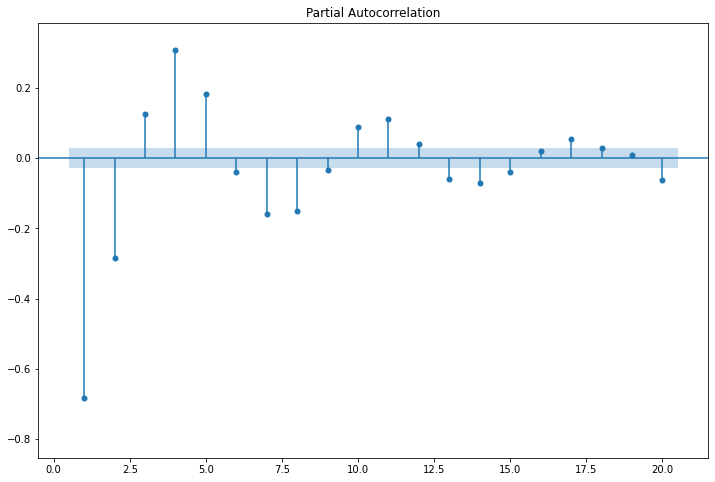

In [7]:
df = MA(5000, np.array([1, 1]), 0, np.array([-1, 0.8]), 200)

plt.rc("figure", figsize=(12,8))
plot_acf(df, lags = 20, zero = False, auto_ylims = True);
plot_pacf(df, lags = 20, zero = False, auto_ylims = True);

##### AR(2) model with these parameters overflows - it just increases to infinity

# Ex. 2: ARIMA forecasting

In [8]:
df=pd.read_csv('INVCMRMT.csv', index_col='DATE', parse_dates=True) 
df.index.freq = 'MS'
df.head()

,INVCMRMT
DATE,
1997-01-01,1301161.0
1997-02-01,1307080.0
1997-03-01,1303978.0
1997-04-01,1319740.0
1997-05-01,1327294.0


C:\Users\Rudy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


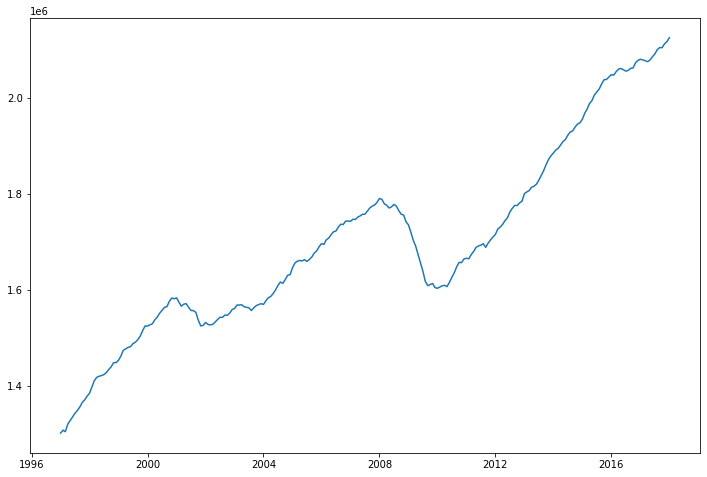

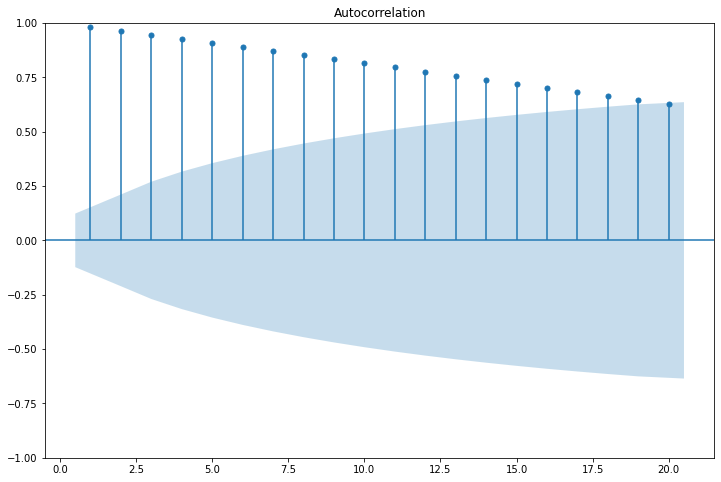

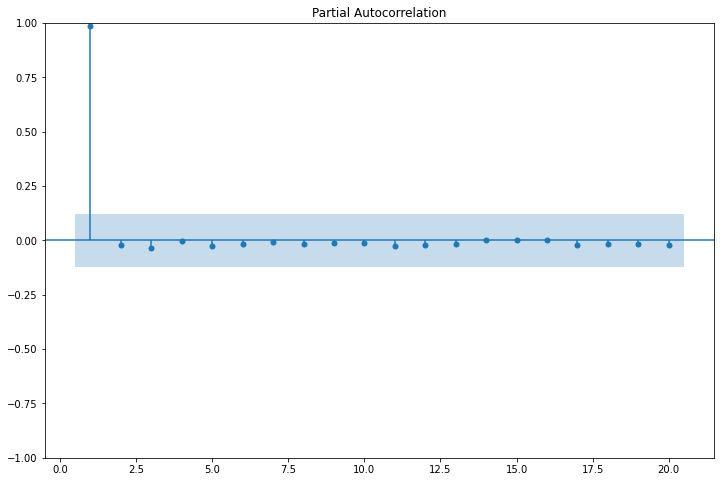

In [9]:
plt.rc("figure", figsize=(12,8))
plt.plot(df)
plot_acf(df, lags=20, zero=False);
plot_pacf(df, lags=20, zero=False);

### Differencing to check for stationarity

In [10]:
df1 = df.diff().dropna()
df1.head(10)

,INVCMRMT
DATE,
1997-02-01,5919.0
1997-03-01,-3102.0
1997-04-01,15762.0
1997-05-01,7554.0
1997-06-01,7394.0
1997-07-01,7622.0
1997-08-01,5933.0
1997-09-01,7596.0
1997-10-01,9131.0


In [62]:
adfuller(df1) # null hypothesis: time series is non-stationary

(-4.399167786660862,
 0.0002978408777548835,
 2,
 249,
 {'1%': -3.4568881317725864,
  '5%': -2.8732185133016057,
  '10%': -2.5729936189738876},
 4654.393102315839)

##### p value is very low - we have to reject the null hypothesis so time series is stationary

C:\Users\Rudy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


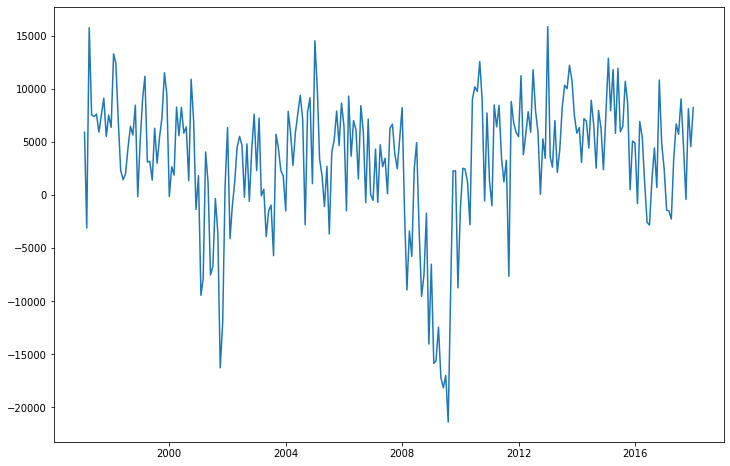

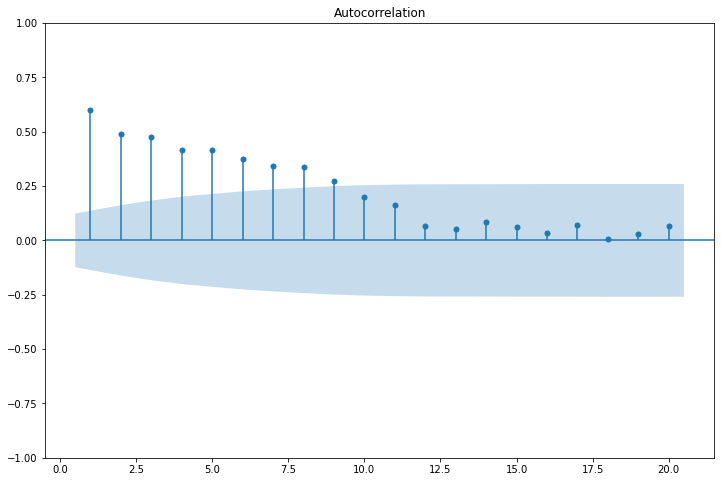

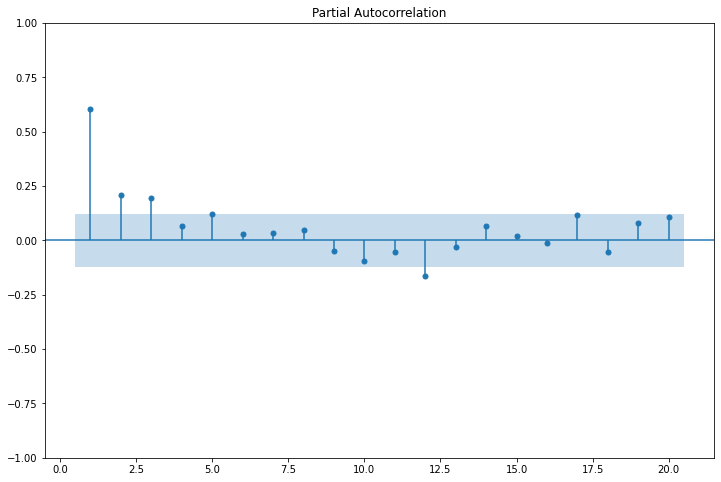

In [12]:
plt.plot(df1)
plot_acf(df1, lags=20, zero=False);
plot_pacf(df1, lags=20, zero=False);

### LLR test

In [13]:
def LLR_test1(m1, m2, DF = 1):
    L1 = m1.llf
    L2 = m2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF).round(3)
    return p

### ARIMA models grid search based on AIC

In [53]:
#ignoring warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #starting model, should be the worst one
    model = ARIMA(df1, order = (0, 0, 0)).fit()
    aic = model.aic
    p = 0
    q = 0

    #loop to test different models
    for i in range (0, 5):
        for j in range(0, 5):
            print('Testing model (' + str(i) + ", 0, " + str(j) + ")")
            model = ARIMA(df1, order = (i, 0, j)).fit()

            #if the aic is lower, model is better
            if(model.aic < aic):
                aic = model.aic
                p = i
                q = j

    print('Best model based on AIC: ARIMA(' + str(p) + ", 0, " + str(q) + ")")

Testing model (0, 0, 0)
Testing model (0, 0, 1)
Testing model (0, 0, 2)
Testing model (0, 0, 3)
Testing model (0, 0, 4)
Testing model (1, 0, 0)
Testing model (1, 0, 1)
Testing model (1, 0, 2)
Testing model (1, 0, 3)
Testing model (1, 0, 4)
Testing model (2, 0, 0)
Testing model (2, 0, 1)
Testing model (2, 0, 2)
Testing model (2, 0, 3)
Testing model (2, 0, 4)
Testing model (3, 0, 0)
Testing model (3, 0, 1)
Testing model (3, 0, 2)
Testing model (3, 0, 3)
Testing model (3, 0, 4)
Testing model (4, 0, 0)
Testing model (4, 0, 1)
Testing model (4, 0, 2)
Testing model (4, 0, 3)
Testing model (4, 0, 4)
Best model based on AIC: ARIMA(2, 0, 2)


### Comparing with auto arima

In [25]:
auto_arima(df1, seasonal = False, trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5181.327, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5023.255, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5086.514, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5009.769, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4999.518, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4999.999, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4996.073, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4995.007, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4995.031, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4994.562, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5075.771, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4995.674, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5057.643, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2493.281
Date:                Tue, 26 Apr 2022   AIC                           4994.562
Time:                        12:04:28   BIC                           5008.680
Sample:                             0   HQIC                          5000.243
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9510      0.027     35.679      0.000       0.899       1.003
ma.L1         -0.5168      0.062     -8.304      0.000      -0.639      -0.395
ma.L2         -0.1067      0.066     -1.615      0.106      -0.236       0.023
sigma2      2.241e+07   3.27e-10   6.84e+16      0.000    2.24e+07    2.24e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.80   Prob(JB):                         0.84
Heteroskedasticity (H):               0.76   Skew:                            -0.04
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.41e+33. Standard errors may be unstable.
"""

### Auto ARIMA says that (1, 0, 2) is the best but according to my tests (2, 0, 2) is better.

In [55]:
train = df1.iloc[:-12]
test = df1.iloc[-12:]
start = len(train)
end = start + len(test) - 1

In [56]:
model = ARIMA(train, order = (2, 0, 2), enforce_invertibility = False)
res = model.fit()
model_auto = ARIMA(train, order = (1, 0, 2), enforce_invertibility = False)
res_auto = model_auto.fit()

In [57]:
forecast = res.predict(start = start, end = end, dynamic = False).rename('Forecast ARIMA(2, 0, 2)')
forecast_auto = res_auto.predict(start = start, end = end, dynamic = False).rename('Forecast ARIMA(1, 0, 2)')

<AxesSubplot:xlabel='DATE'>

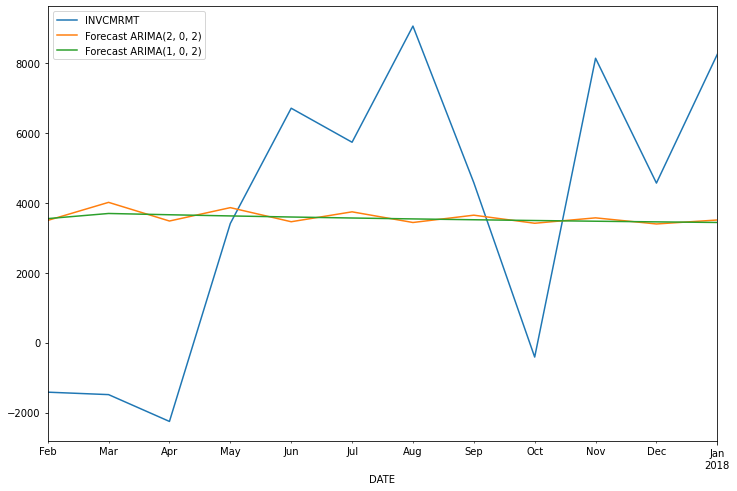

In [58]:
ax = test.plot()
forecast.plot(ax = ax, legend = True)
forecast_auto.plot(ax = ax, legend = True)

In [60]:
print("MAE for ARIMA(2, 0, 2): " + str(mean_absolute_error(test, forecast)))
print("MAE for ARIMA(1, 0, 2): " + str(mean_absolute_error(test, forecast_auto)))

MAE for ARIMA(2, 0, 2): 3556.461253777117
MAE for ARIMA(1, 0, 2): 3550.635687957
